In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np
import pandas as pd

import skimage.io as io
io.use_plugin('matplotlib')

import menpo
import menpo.io as mio
from menpowidgets import visualize_images
from pathlib import Path

from tqdm import tqdm

## Load

In [3]:
unfam_df = pd.read_csv("/data1/famface01/analysis/encoding/12_Features/unfam_final_frame_df.csv")
unfam_df = unfam_df.ix[:,1:]
unfam_df.head()

,vnum,vid,frame,category,fpath
0,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,3,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
1,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,9,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
2,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,15,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
3,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,21,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
4,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,27,unfam,/data1/famface01/data/stimuli/vids/eight_frame...


In [4]:
from menpo.landmark import face_ibug_68_to_face_ibug_68_trimesh, face_ibug_68_to_face_ibug_68, labeller

unfam_images = []
for i,row in tqdm(unfam_df.iterrows(), total=len(unfam_df)):
    img = mio.import_image(row.fpath)
    img = img.crop_to_landmarks_proportion(0.1)
    labeller(img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
    unfam_images.append(img)

100%|██████████| 6912/6912 [03:24<00:00, 33.81it/s]


In [14]:
from menpofit.aam import HolisticAAM
HolisticAAM??

In [63]:
from menpo.shape import mean_pointcloud, PointCloud
from menpofit.builder import (compute_reference_shape, rescale_images_to_reference_shape, 
                              warp_images, build_reference_frame, align_shapes)
from menpofit.transform import DifferentiablePiecewiseAffine

diagonal = 200
verbose = True
group = 'PTS'

ref_shape = compute_reference_shape([i.landmarks[group].lms for i in unfam_images], diagonal, verbose=verbose)

- Computing reference shape                                                     

In [50]:
shape_batch = [i.landmarks['PTS'].lms for i in unfam_images]
mean_aligned_shape = mean_pointcloud(align_shapes(shape_batch))
reference_frame = build_reference_frame(mean_aligned_shape)

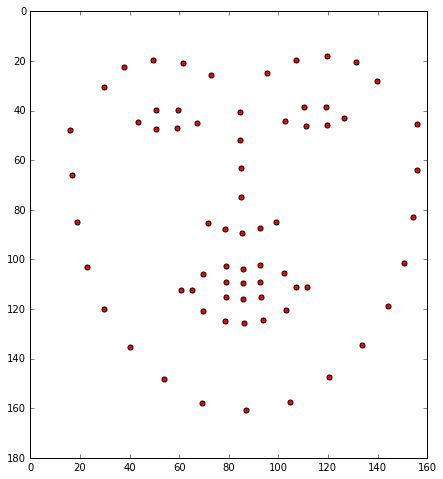

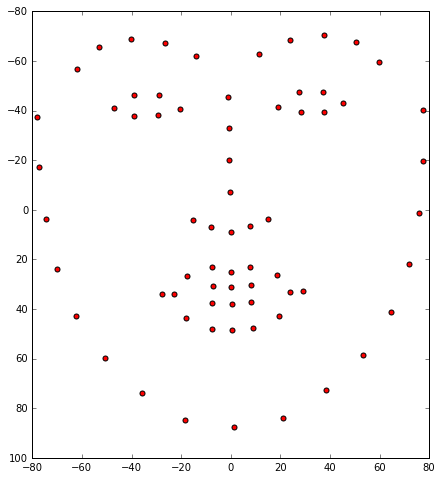

In [56]:
# Ref shape is the literal position
# While the aligned shape has been centered
ref_shape.view(new_figure=True)
mean_aligned_shape.view(new_figure=True)

In [52]:
image_batch = rescale_images_to_reference_shape(unfam_images, 'PTS', mean_aligned_shape, verbose=verbose)
shape_batch = [i.landmarks['PTS'].lms for i in image_batch]

- Normalizing images size: [==========] 100% (6912/6912) - done.                

In [57]:
scale_prefix = '  - '
warped_images = warp_images(image_batch, shape_batch, reference_frame, DifferentiablePiecewiseAffine,
                               prefix=scale_prefix, verbose=True)

  - Warping images: [==========] 100% (6912/6912) - done.                       

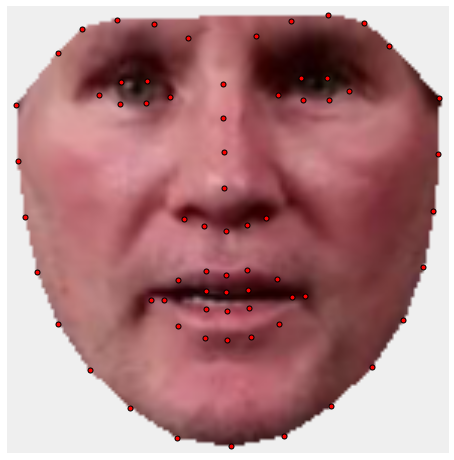

In [15]:
visualize_images(warped_images)

In [59]:
imgs = np.array([ img.pixels for img in warped_images ])
ave_img0 = np.mean(imgs, axis=0)
ave_img0.shape

(3, 165, 162)

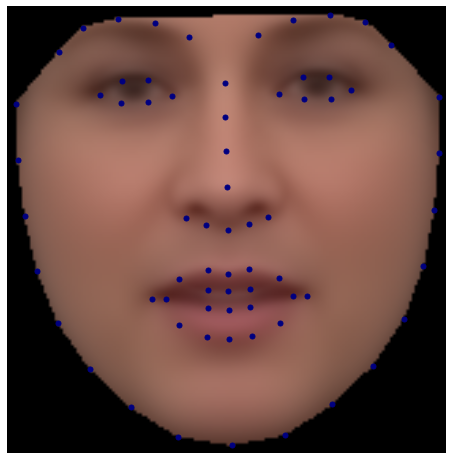

In [75]:
ave_shape = PointCloud(mean_aligned_shape.points + np.array([(165-18)/2.,(162)/2.])[np.newaxis,:])
ave_img = menpo.image.Image(ave_img0)
ave_img.landmarks['PTS'] = ave_shape
ave_img.view_landmarks(group='PTS')

In [105]:
#from menpo.image.masked import MaskedImage
masked_images = [ img.as_masked().constrain_mask_to_landmarks(group='PTS') for img in tqdm(unfam_images) ]

100%|██████████| 6912/6912 [15:42<00:00,  3.74it/s]


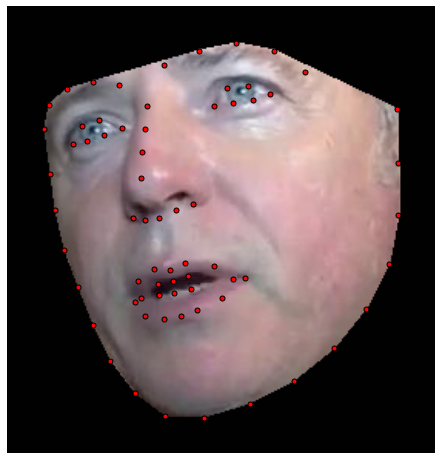

In [106]:
visualize_images(masked_images)

In [111]:
from menpo.io.output import export_image, export_landmark_file

odir = '/data1/famface01/data/stimuli/vids/masked_images'
if not os.path.exists(odir): os.mkdir(odir)

In [114]:
export_image(ave_img, '%s/average_face.jpg' % odir, overwrite=True)
export_landmark_file(ave_img.landmarks['PTS'], '%s/average_face.pts' % odir, overwrite=True)

In [118]:
for i,row in tqdm(unfam_df.iterrows(), total=unfam_df.shape[0]):
    mimg = masked_images[i]
    end_path = row.fpath.replace('/data1/famface01/data/stimuli/vids/eight_frames/final/', '')
    end_land_path = end_path.replace('.jpg', '.pts')
    
    base_dir = "%s/%s" % (odir, os.path.dirname(end_path))
    if not os.path.exists(base_dir): os.mkdir(base_dir)
    
    export_image(mimg, '%s/%s' % (odir, end_path), overwrite=True)
    export_landmark_file(mimg.landmarks['PTS'], '%s/%s' % (odir, end_land_path), overwrite=True)

100%|██████████| 6912/6912 [01:46<00:00, 64.75it/s]


## Neural Network Setup

We now copy over the files to be used by the neural network. Note these command to be only run on hnl11.

In [ ]:
## DON'T RUN!

ssh hnl11

# Copy over files
mkdir ~/Downloads/tmp_masked_sf
mkdir ~/Downloads/tmp_masked_sf_nn
cp /data1/famface01/data/stimuli/vids/masked_images/*/*jpg ~/Downloads/tmp_masked_sf
cp /data1/famface01/data/stimuli/vids/masked_images/*/*pts ~/Downloads/tmp_masked_sf
cp /data1/famface01/data/stimuli/vids/masked_images/average_face.* ~/Downloads/tmp_masked_sf/
cp ~/Downloads/tmp_sf_nn/use-aligned.py ~/Downloads/tmp_masked_sf_nn/

# Connect
cd ~/Downloads/openface
sudo service docker start
sudo docker run -p 9000:9000 -p 8000:8000 -v ~/Downloads/tmp_masked_sf:/root/openface/masked_frames -v ~/Downloads/tmp_masked_sf_nn:/root/openface/nn_masked_frames -t -i bamos/openface /bin/bash

# Align
cd /root/openface
cp nn_masked_frames/use-aligned.py util/
mkdir nn_masked_frames/align
./util/use-aligned.py masked_frames align outerEyesAndNose nn_masked_frames/align --size 96
./batch-represent/main.lua -data nn_masked_frames/align -outDir nn_masked_frames/